In [1]:
# 📦 Step 0: Import Required Libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

In [2]:
# Add the parent directory to the Python path
# to handle ModuleNotFoundError: No module named 'models' error
import sys
sys.path.append('../') 

from models.lstm_forecast_model import LSTMForecast
from models.timeseries_dataset_class import TimeSeriesDataset


# ✅ Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cpu


In [3]:
# Parameters
window_size = 48
batch_size = 32
epochs = 10
learning_rate = 1e-3
target_column = "OT"

In [4]:
# 📂 Step 1: Load split datasets
train_df = pd.read_csv("../data/processed/etth1_train.csv", parse_dates=["date"], index_col="date")
val_df = pd.read_csv("../data/processed/etth1_val.csv", parse_dates=["date"], index_col="date")
test_df = pd.read_csv("../data/processed/etth1_test.csv", parse_dates=["date"], index_col="date")

train_target = train_df[target_column].values
val_target = val_df[target_column].values
test_target = test_df[target_column].values

In [5]:

# 📊 Step 2: Prepare TimeSeriesDataset and DataLoaders

train_loader = DataLoader(TimeSeriesDataset(train_target, window_size), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(val_target, window_size), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(test_target, window_size), batch_size=batch_size, shuffle=False)


In [6]:
# ⚙️ Step 3: Define and Train the Model
model = LSTMForecast().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device).unsqueeze(1)
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}] Train Loss: {total_loss / len(train_loader):.4f}")

[Epoch 1] Train Loss: 0.0069
[Epoch 2] Train Loss: 0.0011
[Epoch 3] Train Loss: 0.0008
[Epoch 4] Train Loss: 0.0006
[Epoch 5] Train Loss: 0.0006
[Epoch 6] Train Loss: 0.0005
[Epoch 7] Train Loss: 0.0005
[Epoch 8] Train Loss: 0.0004
[Epoch 9] Train Loss: 0.0004
[Epoch 10] Train Loss: 0.0004


In [7]:
# 💾 Step 4: Save the trained model
os.makedirs("../models/checkpoints", exist_ok=True)
torch.save(model.state_dict(), "../models/checkpoints/lstm_model.pth")
print("✅ Model saved to checkpoints/lstm_model.pth")

✅ Model saved to checkpoints/lstm_model.pth


In [8]:
# SMAPE calculation
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # Avoid division by zero
    return 100 * np.mean(diff)


In [9]:
# 📈 Step 5: Validate and Plot Predictions

def evaluate_model(dataloader, title, plot_name):
    model.eval()
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            all_preds.append(pred)
            all_trues.append(y.numpy())


    predictions = np.concatenate(all_preds)
    truths = np.concatenate(all_trues)

    plt.figure(figsize=(10, 5))
    plt.plot(truths[:100], label="True")
    plt.plot(predictions[:100], label="Predicted")
    plt.legend()
    plt.title(title)
    plt.grid(True)
    
    os.makedirs("../../outputs", exist_ok=True)
    plt.savefig(f"../../outputs/{plot_name}")
    print(f"✅ Plot saved to outputs/{plot_name}")
    plt.show()


    # 📊 Metrics
    mse = mean_squared_error(truths, predictions)
    mae = mean_absolute_error(truths, predictions)
    smape_val = smape(truths, predictions)

    print(f"📊 {title} Metrics:")
    print(f" - MSE   : {mse:.6f}")
    print(f" - MAE   : {mae:.6f}")
    print(f" - SMAPE : {smape_val:.2f}%")
    
    return predictions, truths

✅ Plot saved to outputs/lstm_model_val_predictions.png


/var/folders/s8/pp3cmgsj1h3gqdc1dpxr6yzm0000gn/T/ipykernel_15553/420891574.py:26: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(f"../../outputs/{plot_name}")
/Users/beratburakkaya/Documents/iot_timeseries_machine_learning_updated/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


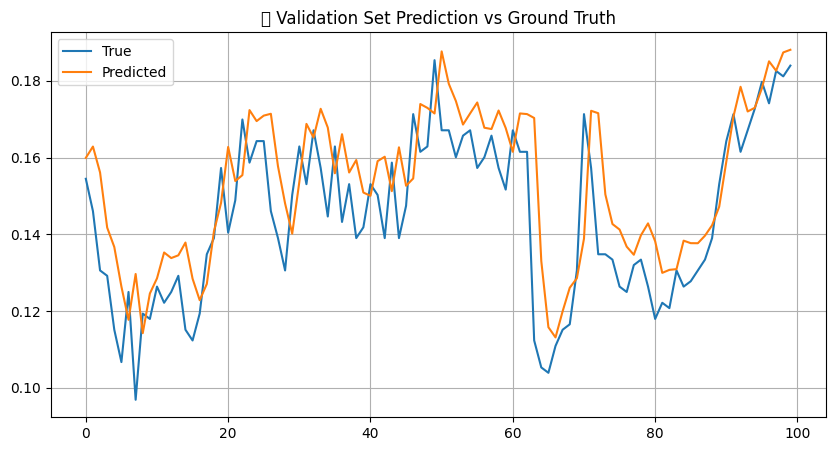

📊 📈 Validation Set Prediction vs Ground Truth Metrics:
 - MSE   : 0.000224
 - MAE   : 0.011375
 - SMAPE : 33.81%
✅ Plot saved to outputs/lstm_model_test_predictions.png


/var/folders/s8/pp3cmgsj1h3gqdc1dpxr6yzm0000gn/T/ipykernel_15553/420891574.py:26: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(f"../../outputs/{plot_name}")
/Users/beratburakkaya/Documents/iot_timeseries_machine_learning_updated/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


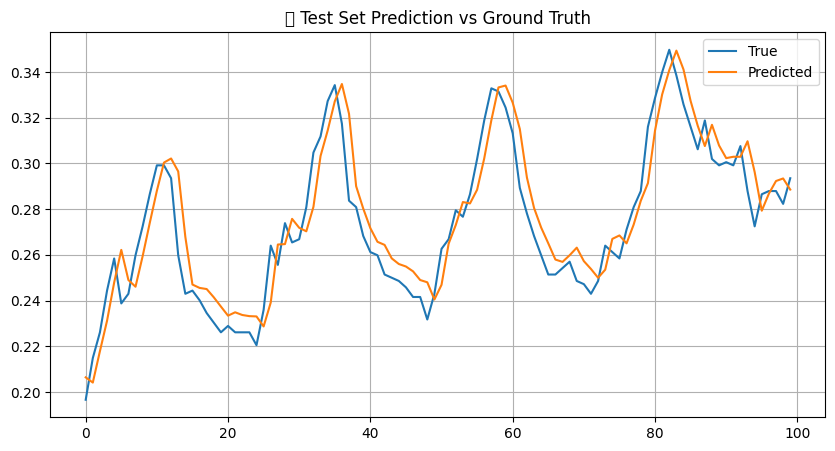

📊 📈 Test Set Prediction vs Ground Truth Metrics:
 - MSE   : 0.000193
 - MAE   : 0.009716
 - SMAPE : 18.27%


(array([[0.20642489],
        [0.20414749],
        [0.2179009 ],
        ...,
        [0.30622584],
        [0.29345757],
        [0.280962  ]], shape=(1694, 1), dtype=float32),
 array([0.19661789, 0.2148861 , 0.22612654, ..., 0.28652146, 0.27667856,
        0.2724659 ], shape=(1694,), dtype=float32))

In [10]:
# Evaluate on validation and test sets
evaluate_model(val_loader, "📈 Validation Set Prediction vs Ground Truth", "lstm_model_val_predictions.png")
evaluate_model(test_loader, "📈 Test Set Prediction vs Ground Truth", "lstm_model_test_predictions.png")